In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
import itertools
import time
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score

In [2]:
data = pd.read_csv('expanded', delimiter='\t', header=None, names=['characteristics'])
data = data['characteristics'].str.split(',', expand=True)
data = data.drop(range(7)).reset_index(drop=True)



In [3]:
# implement descriptive column names
column_names = ['edibility','cap_shape', 'cap_surface', 'cap_color', 'bruises', 
                'odor', 'gill_attachment', 'gill_spacing', 'gill_size', 'gill_color', 
                'stalk_shape', 'stalk_root', 'stalk_surface_above_ring', 'stalk_surface_below_ring', 
                'stalk_color_above_ring', 'stalk_color_below_ring', 'veil_type', 'veil_color', 
                'ring_number', 'ring_type', 'spore_print_color', 'population','habitat']
data.columns = column_names
data = data.drop(data[data.isnull().any(axis=1)].index)

In [4]:
# get dummy variables for two-level response
def var_transform (data):
    data['edibility']=data['edibility'].apply(lambda x: 1 if x=='EDIBLE' else 0)
    #data['odor']=data['odor'].apply(lambda x: 0 if x=='ALMOND' or x=='ANISE' else 1)
    # put further variable transformation here 
    return data
var_transform(data).head(2)

,edibility,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,1,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
1,1,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,...,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS


In [5]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load the dataset
df=data
# Convert categorical variables to dummy variables
df = pd.get_dummies(df, columns=['cap_shape', 'cap_surface', 'cap_color', 'bruises', 
                'odor', 'gill_attachment', 'gill_spacing', 'gill_size', 'gill_color', 
                'stalk_shape', 'stalk_root', 'stalk_surface_above_ring', 'stalk_surface_below_ring', 
                'stalk_color_above_ring', 'stalk_color_below_ring', 'veil_type', 'veil_color', 
                'ring_number', 'ring_type', 'spore_print_color', 'population','habitat'], drop_first=True)
# Calculate VIF for each predictor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif["Predictor"] = df.columns

# Print the VIF values
vif

/Users/lucyhan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,Predictor
0,inf,edibility
1,1.340183,cap_shape_CONICAL
2,8.278594,cap_shape_CONVEX
3,8.645659,cap_shape_FLAT
4,3.856771,cap_shape_KNOBBED
...,...,...
91,1.930608,habitat_MEADOWS
92,3.292256,habitat_PATHS
93,2.587564,habitat_URBAN
94,inf,habitat_WASTE


In [6]:
df.columns

Index(['edibility', 'cap_shape_CONICAL', 'cap_shape_CONVEX', 'cap_shape_FLAT',
       'cap_shape_KNOBBED', 'cap_shape_SUNKEN', 'cap_surface_GROOVES',
       'cap_surface_SCALY', 'cap_surface_SMOOTH', 'cap_color_BUFF',
       'cap_color_CINNAMON', 'cap_color_GRAY', 'cap_color_GREEN',
       'cap_color_PINK', 'cap_color_PURPLE', 'cap_color_RED',
       'cap_color_WHITE', 'cap_color_YELLOW', 'bruises_NO', 'odor_ANISE',
       'odor_CREOSOTE', 'odor_FISHY', 'odor_FOUL', 'odor_MUSTY', 'odor_NONE',
       'odor_PUNGENT', 'odor_SPICY', 'gill_attachment_FREE',
       'gill_spacing_CROWDED', 'gill_size_NARROW', 'gill_color_BROWN',
       'gill_color_BUFF', 'gill_color_CHOCOLATE', 'gill_color_GRAY',
       'gill_color_GREEN', 'gill_color_ORANGE', 'gill_color_PINK',
       'gill_color_PURPLE', 'gill_color_RED', 'gill_color_WHITE',
       'gill_color_YELLOW', 'stalk_shape_TAPERING', 'stalk_root_BULBOUS',
       'stalk_root_CLUB', 'stalk_root_EQUAL', 'stalk_root_ROOTED',
       'stalk_surface_above

In [7]:
vif_inf = vif[np.isinf(vif['VIF Factor'])]
vif_inf

,VIF Factor,Predictor
0,inf,edibility
18,inf,bruises_NO
20,inf,odor_CREOSOTE
21,inf,odor_FISHY
22,inf,odor_FOUL
23,inf,odor_MUSTY
24,inf,odor_NONE
25,inf,odor_PUNGENT
26,inf,odor_SPICY
29,inf,gill_size_NARROW


In [8]:
# create dummy variables for each categorical variable
cat_vars = list(data.select_dtypes(include=['object']).columns)
dummy_vars = pd.get_dummies(data[cat_vars], prefix=cat_vars)
# concatenate the dummy variables with the original dataset
data = pd.concat([data.drop(cat_vars, axis=1), dummy_vars], axis=1)

print(data.shape)

(8416, 118)


# Feature Selection

In [9]:
import itertools
import time
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('ggplot')

In [10]:
data.head()

,edibility,cap_shape_BELL,cap_shape_CONICAL,cap_shape_CONVEX,cap_shape_FLAT,cap_shape_KNOBBED,cap_shape_SUNKEN,cap_surface_FIBROUS,cap_surface_GROOVES,cap_surface_SCALY,...,population_SCATTERED,population_SEVERAL,population_SOLITARY,habitat_GRASSES,habitat_LEAVES,habitat_MEADOWS,habitat_PATHS,habitat_URBAN,habitat_WASTE,habitat_WOODS
0,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [11]:
from sklearn.model_selection import train_test_split
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['edibility'], axis=1),
    data['edibility'],
    test_size=0.15,
    random_state=23)

X_train.shape, X_test.shape

((7153, 117), (1263, 117))

In [12]:
cutoff=0.5
def fit_linear_reg(X,Y):
    # Fit linear regression model and return classification accuracy
    model_k = linear_model.LinearRegression()
    model_k.fit(X, Y)

    # Predicted vs Actual
    actual_values = Y
    pred_values = model_k.predict(X)
    bins = np.array([0, cutoff, 1])
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]

    # Calculate the accuracy
    accuracy = (cm[0,0] + cm[1,1]) / cm.sum()
    fpr = (cm[0,1]) / (cm[0,0] + cm[0,1])
    #tpr = (cm[1,1]) / (cm[1,0] + cm[1,1])

    print("Classification accuracy = {:.1%}".format(accuracy))
    #print("TPR or Recall = {:.1%}".format(tpr))
    print("FPR = {:.1%}".format(fpr))

    return accuracy, fpr

In [13]:
#forward selection
k = 117

remaining_features = list(X_train.columns.values)
features = []
accuracy_list, fpr_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

for i in range(1,k+1):
    best_accuracy = np.inf
    
    for combo in itertools.combinations(remaining_features,1):

            accuracy = fit_linear_reg(X_train[list(combo) + features],y_train)   #Store temp result 

            if accuracy[0] < best_accuracy:
                best_accuracy = accuracy[0]
                best_fpr = accuracy[1] 
                best_feature = combo[0]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    #Saving values for plotting
    accuracy_list.append(best_accuracy)
    fpr_list.append(best_fpr)
    features_list[i] = features.copy()

Classification accuracy = 53.2%
FPR = 100.0%
Classification accuracy = 53.3%
FPR = 99.9%
Classification accuracy = 53.2%
FPR = 100.0%
Classification accuracy = 53.2%
FPR = 100.0%
Classification accuracy = 57.4%
FPR = 84.8%
Classification accuracy = 53.1%
FPR = 100.0%
Classification accuracy = 57.7%
FPR = 19.4%
Classification accuracy = 53.3%
FPR = 100.0%
Classification accuracy = 55.9%
FPR = 55.7%
Classification accuracy = 55.0%
FPR = 63.9%
Classification accuracy = 53.2%
FPR = 100.0%
Classification accuracy = 54.1%
FPR = 96.9%
Classification accuracy = 53.2%
FPR = 100.0%
Classification accuracy = 53.2%
FPR = 100.0%
Classification accuracy = 53.2%
FPR = 100.0%
Classification accuracy = 53.7%
FPR = 97.5%
Classification accuracy = 53.1%
FPR = 100.0%
Classification accuracy = 56.1%
FPR = 77.9%
Classification accuracy = 53.2%
FPR = 100.0%
Classification accuracy = 56.3%
FPR = 83.3%
Classification accuracy = 71.9%
FPR = 16.2%
Classification accuracy = 71.9%
FPR = 16.2%
Classification accura

Classification accuracy = 50.0%
FPR = 0.0%
Classification accuracy = 50.2%
FPR = 0.0%
Classification accuracy = 54.2%
FPR = 0.0%
Classification accuracy = 54.2%
FPR = 0.0%
Classification accuracy = 55.8%
FPR = 0.2%
Classification accuracy = 53.6%
FPR = 0.0%
Classification accuracy = 50.1%
FPR = 100.0%
Classification accuracy = 58.3%
FPR = 3.1%
Classification accuracy = 58.9%
FPR = 1.9%
Classification accuracy = 55.7%
FPR = 55.6%
Classification accuracy = 50.5%
FPR = 0.0%
Classification accuracy = 62.9%
FPR = 100.0%
Classification accuracy = 50.1%
FPR = 100.0%
Classification accuracy = 72.3%
FPR = 21.4%
Classification accuracy = 67.3%
FPR = 6.0%
Classification accuracy = 68.6%
FPR = 6.0%
Classification accuracy = 50.8%
FPR = 0.0%
Classification accuracy = 71.5%
FPR = 59.7%
Classification accuracy = 50.3%
FPR = 100.0%
Classification accuracy = 50.5%
FPR = 0.0%
Classification accuracy = 50.5%
FPR = 0.0%
Classification accuracy = 65.2%
FPR = 54.2%
Classification accuracy = 50.5%
FPR = 0.0%

Classification accuracy = 54.8%
FPR = 1.0%
Classification accuracy = 53.7%
FPR = 0.0%
Classification accuracy = 52.9%
FPR = 43.1%
Classification accuracy = 53.5%
FPR = 59.1%
Classification accuracy = 54.4%
FPR = 84.4%
Classification accuracy = 50.6%
FPR = 0.0%
Classification accuracy = 60.1%
FPR = 19.3%
Classification accuracy = 53.6%
FPR = 0.0%
Classification accuracy = 58.3%
FPR = 55.7%
Classification accuracy = 51.9%
FPR = 63.6%
Classification accuracy = 53.5%
FPR = 25.9%
Classification accuracy = 51.0%
FPR = 96.3%
Classification accuracy = 53.8%
FPR = 0.3%
Classification accuracy = 55.7%
FPR = 21.1%
Classification accuracy = 53.7%
FPR = 0.0%
Classification accuracy = 50.5%
FPR = 96.9%
Classification accuracy = 56.5%
FPR = 77.8%
Classification accuracy = 58.4%
FPR = 8.3%
Classification accuracy = 53.1%
FPR = 83.5%
Classification accuracy = 72.1%
FPR = 16.2%
Classification accuracy = 72.1%
FPR = 16.2%
Classification accuracy = 56.5%
FPR = 0.0%
Classification accuracy = 58.3%
FPR = 0.

Classification accuracy = 56.3%
FPR = 1.9%
Classification accuracy = 55.4%
FPR = 55.9%
Classification accuracy = 68.9%
FPR = 66.4%
Classification accuracy = 53.6%
FPR = 0.0%
Classification accuracy = 74.7%
FPR = 21.4%
Classification accuracy = 67.8%
FPR = 6.0%
Classification accuracy = 69.0%
FPR = 6.1%
Classification accuracy = 54.1%
FPR = 0.0%
Classification accuracy = 70.1%
FPR = 59.5%
Classification accuracy = 51.1%
FPR = 97.5%
Classification accuracy = 50.8%
FPR = 0.0%
Classification accuracy = 50.8%
FPR = 0.0%
Classification accuracy = 67.3%
FPR = 54.5%
Classification accuracy = 50.8%
FPR = 0.0%
Classification accuracy = 60.0%
FPR = 0.0%
Classification accuracy = 56.8%
FPR = 1.4%
Classification accuracy = 58.7%
FPR = 0.0%
Classification accuracy = 61.1%
FPR = 9.8%
Classification accuracy = 75.2%
FPR = 28.1%
Classification accuracy = 53.5%
FPR = 16.8%
Classification accuracy = 62.1%
FPR = 19.1%
Classification accuracy = 57.1%
FPR = 84.7%
Classification accuracy = 56.3%
FPR = 1.0%
C

Classification accuracy = 58.9%
FPR = 0.0%
Classification accuracy = 61.3%
FPR = 9.8%
Classification accuracy = 75.4%
FPR = 28.1%
Classification accuracy = 53.6%
FPR = 16.8%
Classification accuracy = 62.5%
FPR = 19.1%
Classification accuracy = 57.4%
FPR = 82.3%
Classification accuracy = 56.7%
FPR = 1.0%
Classification accuracy = 64.1%
FPR = 72.1%
Classification accuracy = 53.4%
FPR = 89.8%
Classification accuracy = 52.6%
FPR = 0.0%
Classification accuracy = 51.9%
FPR = 30.4%
Classification accuracy = 56.1%
FPR = 1.0%
Classification accuracy = 54.6%
FPR = 0.0%
Classification accuracy = 54.4%
FPR = 41.3%
Classification accuracy = 54.0%
FPR = 57.0%
Classification accuracy = 55.2%
FPR = 81.9%
Classification accuracy = 60.7%
FPR = 19.3%
Classification accuracy = 54.4%
FPR = 0.0%
Classification accuracy = 58.8%
FPR = 53.6%
Classification accuracy = 52.5%
FPR = 62.4%
Classification accuracy = 53.4%
FPR = 25.9%
Classification accuracy = 51.8%
FPR = 0.0%
Classification accuracy = 54.4%
FPR = 0.

Classification accuracy = 56.3%
FPR = 82.0%
Classification accuracy = 62.3%
FPR = 17.9%
Classification accuracy = 54.3%
FPR = 98.1%
Classification accuracy = 60.2%
FPR = 52.6%
Classification accuracy = 53.4%
FPR = 63.5%
Classification accuracy = 52.6%
FPR = 70.9%
Classification accuracy = 52.5%
FPR = 94.3%
Classification accuracy = 54.4%
FPR = 1.0%
Classification accuracy = 58.4%
FPR = 20.3%
Classification accuracy = 54.6%
FPR = 98.1%
Classification accuracy = 58.2%
FPR = 75.1%
Classification accuracy = 60.2%
FPR = 7.5%
Classification accuracy = 54.4%
FPR = 81.0%
Classification accuracy = 73.7%
FPR = 16.5%
Classification accuracy = 73.6%
FPR = 16.5%
Classification accuracy = 54.9%
FPR = 0.6%
Classification accuracy = 57.6%
FPR = 0.7%
Classification accuracy = 58.5%
FPR = 97.0%
Classification accuracy = 80.0%
FPR = 40.5%
Classification accuracy = 54.7%
FPR = 98.1%
Classification accuracy = 88.2%
FPR = 2.5%
Classification accuracy = 53.2%
FPR = 97.3%
Classification accuracy = 61.6%
FPR =

Classification accuracy = 58.6%
FPR = 20.7%
Classification accuracy = 55.1%
FPR = 94.9%
Classification accuracy = 59.8%
FPR = 70.8%
Classification accuracy = 60.4%
FPR = 7.6%
Classification accuracy = 55.5%
FPR = 76.6%
Classification accuracy = 74.6%
FPR = 13.4%
Classification accuracy = 74.6%
FPR = 13.4%
Classification accuracy = 55.4%
FPR = 0.0%
Classification accuracy = 58.3%
FPR = 0.0%
Classification accuracy = 59.7%
FPR = 91.5%
Classification accuracy = 79.6%
FPR = 41.5%
Classification accuracy = 55.5%
FPR = 94.8%
Classification accuracy = 88.0%
FPR = 2.6%
Classification accuracy = 54.4%
FPR = 92.3%
Classification accuracy = 62.7%
FPR = 78.4%
Classification accuracy = 56.5%
FPR = 1.3%
Classification accuracy = 56.5%
FPR = 1.3%
Classification accuracy = 73.2%
FPR = 0.2%
Classification accuracy = 73.2%
FPR = 0.2%
Classification accuracy = 77.6%
FPR = 41.1%
Classification accuracy = 77.6%
FPR = 41.1%
Classification accuracy = 56.4%
FPR = 1.7%
Classification accuracy = 64.0%
FPR = 1.7

Classification accuracy = 74.5%
FPR = 14.0%
Classification accuracy = 74.5%
FPR = 14.0%
Classification accuracy = 57.8%
FPR = 0.6%
Classification accuracy = 60.5%
FPR = 0.6%
Classification accuracy = 59.7%
FPR = 92.1%
Classification accuracy = 79.4%
FPR = 41.3%
Classification accuracy = 55.8%
FPR = 0.7%
Classification accuracy = 88.7%
FPR = 2.6%
Classification accuracy = 54.3%
FPR = 94.4%
Classification accuracy = 62.6%
FPR = 78.8%
Classification accuracy = 56.6%
FPR = 1.3%
Classification accuracy = 56.5%
FPR = 1.3%
Classification accuracy = 73.2%
FPR = 0.9%
Classification accuracy = 73.2%
FPR = 0.9%
Classification accuracy = 77.8%
FPR = 41.1%
Classification accuracy = 77.8%
FPR = 41.1%
Classification accuracy = 56.8%
FPR = 2.3%
Classification accuracy = 64.3%
FPR = 2.3%
Classification accuracy = 67.1%
FPR = 87.3%
Classification accuracy = 58.2%
FPR = 81.9%
Classification accuracy = 55.4%
FPR = 81.0%
Classification accuracy = 55.9%
FPR = 1.0%
Classification accuracy = 53.1%
FPR = 1.2%


Classification accuracy = 56.8%
FPR = 0.8%
Classification accuracy = 59.8%
FPR = 20.8%
Classification accuracy = 56.5%
FPR = 0.7%
Classification accuracy = 59.7%
FPR = 70.2%
Classification accuracy = 61.9%
FPR = 7.6%
Classification accuracy = 55.7%
FPR = 77.2%
Classification accuracy = 75.3%
FPR = 13.5%
Classification accuracy = 75.3%
FPR = 13.5%
Classification accuracy = 58.6%
FPR = 0.0%
Classification accuracy = 61.1%
FPR = 0.0%
Classification accuracy = 59.7%
FPR = 91.3%
Classification accuracy = 79.7%
FPR = 40.8%
Classification accuracy = 56.6%
FPR = 0.7%
Classification accuracy = 88.6%
FPR = 2.6%
Classification accuracy = 54.3%
FPR = 93.6%
Classification accuracy = 62.7%
FPR = 78.2%
Classification accuracy = 57.0%
FPR = 0.7%
Classification accuracy = 57.0%
FPR = 0.7%
Classification accuracy = 74.1%
FPR = 0.4%
Classification accuracy = 74.1%
FPR = 0.4%
Classification accuracy = 78.0%
FPR = 40.7%
Classification accuracy = 78.0%
FPR = 40.7%
Classification accuracy = 57.6%
FPR = 1.7%


Classification accuracy = 61.6%
FPR = 49.3%
Classification accuracy = 55.2%
FPR = 62.1%
Classification accuracy = 55.5%
FPR = 66.7%
Classification accuracy = 56.9%
FPR = 0.2%
Classification accuracy = 60.4%
FPR = 19.9%
Classification accuracy = 56.7%
FPR = 0.0%
Classification accuracy = 59.8%
FPR = 70.4%
Classification accuracy = 63.0%
FPR = 6.2%
Classification accuracy = 56.2%
FPR = 76.4%
Classification accuracy = 75.9%
FPR = 12.3%
Classification accuracy = 75.9%
FPR = 12.3%
Classification accuracy = 58.9%
FPR = 0.0%
Classification accuracy = 61.5%
FPR = 0.0%
Classification accuracy = 59.9%
FPR = 92.2%
Classification accuracy = 73.4%
FPR = 85.4%
Classification accuracy = 56.5%
FPR = 0.0%
Classification accuracy = 89.7%
FPR = 0.6%
Classification accuracy = 54.8%
FPR = 92.9%
Classification accuracy = 62.7%
FPR = 78.6%
Classification accuracy = 57.2%
FPR = 0.1%
Classification accuracy = 57.2%
FPR = 0.1%
Classification accuracy = 74.5%
FPR = 0.4%
Classification accuracy = 74.5%
FPR = 0.4%

Classification accuracy = 67.7%
FPR = 7.1%
Classification accuracy = 59.9%
FPR = 0.0%
Classification accuracy = 62.9%
FPR = 2.5%
Classification accuracy = 57.7%
FPR = 0.1%
Classification accuracy = 79.8%
FPR = 35.2%
Classification accuracy = 73.4%
FPR = 32.9%
Classification accuracy = 60.7%
FPR = 2.6%
Classification accuracy = 56.8%
FPR = 1.1%
Classification accuracy = 81.0%
FPR = 35.7%
Classification accuracy = 73.1%
FPR = 32.5%
Classification accuracy = 61.1%
FPR = 80.7%
Classification accuracy = 61.2%
FPR = 80.6%
Classification accuracy = 57.3%
FPR = 0.0%
Classification accuracy = 57.4%
FPR = 0.0%
Classification accuracy = 64.6%
FPR = 58.2%
Classification accuracy = 75.6%
FPR = 34.9%
Classification accuracy = 57.6%
FPR = 0.0%
Classification accuracy = 60.2%
FPR = 80.3%
Classification accuracy = 55.7%
FPR = 91.0%
Classification accuracy = 57.3%
FPR = 0.0%
Classification accuracy = 61.0%
FPR = 0.0%
Classification accuracy = 57.4%
FPR = 0.0%
Classification accuracy = 65.6%
FPR = 58.0%


Classification accuracy = 82.0%
FPR = 7.5%
Classification accuracy = 73.2%
FPR = 3.5%
Classification accuracy = 73.9%
FPR = 3.7%
Classification accuracy = 57.7%
FPR = 87.0%
Classification accuracy = 73.2%
FPR = 52.3%
Classification accuracy = 74.9%
FPR = 40.5%
Classification accuracy = 63.7%
FPR = 0.0%
Classification accuracy = 58.3%
FPR = 86.2%
Classification accuracy = 60.4%
FPR = 0.0%
Classification accuracy = 67.9%
FPR = 3.7%
Classification accuracy = 79.4%
FPR = 22.3%
Classification accuracy = 56.3%
FPR = 17.5%
Classification accuracy = 67.6%
FPR = 17.8%
Classification accuracy = 64.7%
FPR = 71.6%
Classification accuracy = 60.2%
FPR = 0.0%
Classification accuracy = 69.0%
FPR = 60.7%
Classification accuracy = 56.2%
FPR = 27.5%
Classification accuracy = 59.0%
FPR = 0.2%
Classification accuracy = 58.6%
FPR = 60.4%
Classification accuracy = 59.3%
FPR = 35.1%
Classification accuracy = 57.2%
FPR = 33.7%
Classification accuracy = 60.9%
FPR = 72.9%
Classification accuracy = 64.0%
FPR = 17

Classification accuracy = 53.9%
FPR = 47.8%
Classification accuracy = 60.2%
FPR = 19.3%
Classification accuracy = 54.1%
FPR = 47.8%
Classification accuracy = 64.2%
FPR = 39.2%
Classification accuracy = 66.1%
FPR = 15.9%
Classification accuracy = 61.1%
FPR = 45.5%
Classification accuracy = 78.3%
FPR = 6.3%
Classification accuracy = 78.3%
FPR = 6.3%
Classification accuracy = 59.1%
FPR = 0.0%
Classification accuracy = 58.8%
FPR = 0.0%
Classification accuracy = 63.0%
FPR = 77.5%
Classification accuracy = 79.9%
FPR = 43.9%
Classification accuracy = 53.9%
FPR = 47.9%
Classification accuracy = 86.5%
FPR = 0.2%
Classification accuracy = 56.7%
FPR = 60.1%
Classification accuracy = 62.8%
FPR = 78.0%
Classification accuracy = 54.2%
FPR = 47.8%
Classification accuracy = 54.2%
FPR = 47.8%
Classification accuracy = 71.2%
FPR = 0.2%
Classification accuracy = 71.3%
FPR = 0.2%
Classification accuracy = 77.2%
FPR = 47.0%
Classification accuracy = 77.2%
FPR = 47.0%
Classification accuracy = 56.3%
FPR = 4

Classification accuracy = 65.2%
FPR = 2.1%
Classification accuracy = 76.5%
FPR = 54.4%
Classification accuracy = 58.5%
FPR = 36.2%
Classification accuracy = 58.5%
FPR = 35.9%
Classification accuracy = 54.0%
FPR = 47.7%
Classification accuracy = 59.3%
FPR = 49.0%
Classification accuracy = 56.3%
FPR = 48.4%
Classification accuracy = 64.0%
FPR = 3.0%
Classification accuracy = 65.0%
FPR = 36.3%
Classification accuracy = 65.0%
FPR = 36.3%
Classification accuracy = 75.5%
FPR = 41.7%
Classification accuracy = 56.8%
FPR = 25.7%
Classification accuracy = 62.0%
FPR = 1.4%
Classification accuracy = 66.2%
FPR = 3.8%
Classification accuracy = 54.4%
FPR = 48.2%
Classification accuracy = 56.9%
FPR = 50.7%
Classification accuracy = 54.1%
FPR = 47.8%
Classification accuracy = 82.4%
FPR = 33.7%
Classification accuracy = 75.5%
FPR = 28.9%
Classification accuracy = 57.0%
FPR = 50.7%
Classification accuracy = 55.1%
FPR = 48.7%
Classification accuracy = 81.4%
FPR = 36.9%
Classification accuracy = 73.2%
FPR 

Classification accuracy = 57.0%
FPR = 50.5%
Classification accuracy = 54.2%
FPR = 47.7%
Classification accuracy = 81.9%
FPR = 35.9%
Classification accuracy = 75.4%
FPR = 29.1%
Classification accuracy = 57.4%
FPR = 50.6%
Classification accuracy = 56.0%
FPR = 47.8%
Classification accuracy = 81.9%
FPR = 35.9%
Classification accuracy = 73.2%
FPR = 28.2%
Classification accuracy = 62.6%
FPR = 48.4%
Classification accuracy = 62.7%
FPR = 48.3%
Classification accuracy = 55.0%
FPR = 47.3%
Classification accuracy = 65.2%
FPR = 52.7%
Classification accuracy = 76.6%
FPR = 29.6%
Classification accuracy = 53.6%
FPR = 47.7%
Classification accuracy = 61.7%
FPR = 48.0%
Classification accuracy = 60.2%
FPR = 54.8%
Classification accuracy = 55.0%
FPR = 47.3%
Classification accuracy = 57.2%
FPR = 48.1%
Classification accuracy = 53.6%
FPR = 47.7%
Classification accuracy = 68.0%
FPR = 52.5%
Classification accuracy = 74.4%
FPR = 29.3%
Classification accuracy = 54.2%
FPR = 47.7%
Classification accuracy = 53.6%


Classification accuracy = 56.6%
FPR = 48.1%
Classification accuracy = 53.6%
FPR = 47.7%
Classification accuracy = 67.8%
FPR = 52.5%
Classification accuracy = 74.2%
FPR = 29.3%
Classification accuracy = 54.0%
FPR = 47.7%
Classification accuracy = 54.5%
FPR = 47.6%
Classification accuracy = 54.8%
FPR = 47.3%
Classification accuracy = 55.9%
FPR = 47.7%
Classification accuracy = 55.3%
FPR = 47.7%
Classification accuracy = 65.7%
FPR = 40.7%
Classification accuracy = 72.9%
FPR = 63.0%
Classification accuracy = 54.8%
FPR = 47.3%
Classification accuracy = 81.1%
FPR = 7.4%
Classification accuracy = 73.1%
FPR = 3.5%
Classification accuracy = 74.0%
FPR = 3.7%
Classification accuracy = 78.2%
FPR = 41.2%
Classification accuracy = 74.4%
FPR = 41.0%
Classification accuracy = 60.8%
FPR = 0.0%
Classification accuracy = 54.0%
FPR = 47.7%
Classification accuracy = 60.3%
FPR = 0.0%
Classification accuracy = 65.8%
FPR = 4.6%
Classification accuracy = 79.6%
FPR = 21.8%
Classification accuracy = 57.7%
FPR = 

Classification accuracy = 66.5%
FPR = 15.4%
Classification accuracy = 63.7%
FPR = 57.7%
Classification accuracy = 78.3%
FPR = 6.2%
Classification accuracy = 78.4%
FPR = 6.2%
Classification accuracy = 59.4%
FPR = 0.0%
Classification accuracy = 55.2%
FPR = 47.9%
Classification accuracy = 62.6%
FPR = 78.8%
Classification accuracy = 80.6%
FPR = 42.9%
Classification accuracy = 86.6%
FPR = 0.2%
Classification accuracy = 57.7%
FPR = 59.6%
Classification accuracy = 62.1%
FPR = 79.3%
Classification accuracy = 71.5%
FPR = 0.0%
Classification accuracy = 71.6%
FPR = 0.0%
Classification accuracy = 77.9%
FPR = 46.2%
Classification accuracy = 77.9%
FPR = 46.2%
Classification accuracy = 56.5%
FPR = 49.2%
Classification accuracy = 65.5%
FPR = 1.8%
Classification accuracy = 76.6%
FPR = 53.9%
Classification accuracy = 60.9%
FPR = 48.3%
Classification accuracy = 58.7%
FPR = 35.9%
Classification accuracy = 54.4%
FPR = 47.7%
Classification accuracy = 59.6%
FPR = 48.8%
Classification accuracy = 56.1%
FPR = 4

Classification accuracy = 55.8%
FPR = 47.8%
Classification accuracy = 82.0%
FPR = 35.9%
Classification accuracy = 73.3%
FPR = 28.1%
Classification accuracy = 62.9%
FPR = 48.8%
Classification accuracy = 62.9%
FPR = 48.5%
Classification accuracy = 54.5%
FPR = 47.3%
Classification accuracy = 65.3%
FPR = 52.6%
Classification accuracy = 76.6%
FPR = 29.6%
Classification accuracy = 64.2%
FPR = 64.8%
Classification accuracy = 60.5%
FPR = 55.0%
Classification accuracy = 54.5%
FPR = 47.3%
Classification accuracy = 56.9%
FPR = 48.0%
Classification accuracy = 68.3%
FPR = 52.4%
Classification accuracy = 73.6%
FPR = 29.6%
Classification accuracy = 54.5%
FPR = 47.3%
Classification accuracy = 55.4%
FPR = 48.0%
Classification accuracy = 55.8%
FPR = 47.6%
Classification accuracy = 65.7%
FPR = 40.7%
Classification accuracy = 77.5%
FPR = 40.7%
Classification accuracy = 54.5%
FPR = 47.3%
Classification accuracy = 80.8%
FPR = 7.4%
Classification accuracy = 73.1%
FPR = 3.5%
Classification accuracy = 73.5%
FP

Classification accuracy = 57.0%
FPR = 34.2%
Classification accuracy = 61.2%
FPR = 32.7%
Classification accuracy = 60.0%
FPR = 25.5%
Classification accuracy = 62.8%
FPR = 27.8%
Classification accuracy = 60.4%
FPR = 36.8%
Classification accuracy = 60.7%
FPR = 36.5%
Classification accuracy = 77.1%
FPR = 32.1%
Classification accuracy = 58.3%
FPR = 51.0%
Classification accuracy = 61.5%
FPR = 17.7%
Classification accuracy = 67.1%
FPR = 13.2%
Classification accuracy = 59.4%
FPR = 25.2%
Classification accuracy = 61.7%
FPR = 36.3%
Classification accuracy = 55.8%
FPR = 55.6%
Classification accuracy = 82.3%
FPR = 36.2%
Classification accuracy = 75.6%
FPR = 29.1%
Classification accuracy = 61.9%
FPR = 36.4%
Classification accuracy = 59.4%
FPR = 25.4%
Classification accuracy = 82.3%
FPR = 35.9%
Classification accuracy = 73.7%
FPR = 28.2%
Classification accuracy = 65.8%
FPR = 54.8%
Classification accuracy = 65.2%
FPR = 56.8%
Classification accuracy = 55.3%
FPR = 55.1%
Classification accuracy = 65.5%


Classification accuracy = 78.1%
FPR = 5.3%
Classification accuracy = 60.8%
FPR = 34.5%
Classification accuracy = 60.1%
FPR = 42.4%
Classification accuracy = 64.4%
FPR = 74.5%
Classification accuracy = 82.8%
FPR = 43.6%
Classification accuracy = 88.4%
FPR = 0.3%
Classification accuracy = 64.0%
FPR = 76.5%
Classification accuracy = 73.4%
FPR = 9.2%
Classification accuracy = 74.5%
FPR = 9.1%
Classification accuracy = 77.9%
FPR = 44.0%
Classification accuracy = 77.9%
FPR = 44.0%
Classification accuracy = 58.9%
FPR = 43.5%
Classification accuracy = 65.4%
FPR = 0.0%
Classification accuracy = 79.0%
FPR = 40.6%
Classification accuracy = 64.7%
FPR = 56.8%
Classification accuracy = 64.7%
FPR = 56.4%
Classification accuracy = 60.7%
FPR = 40.3%
Classification accuracy = 57.1%
FPR = 47.1%
Classification accuracy = 64.6%
FPR = 19.1%
Classification accuracy = 60.2%
FPR = 42.2%
Classification accuracy = 60.3%
FPR = 42.2%
Classification accuracy = 78.2%
FPR = 30.4%
Classification accuracy = 59.4%
FPR =

Classification accuracy = 66.4%
FPR = 0.0%
Classification accuracy = 64.4%
FPR = 13.2%
Classification accuracy = 66.2%
FPR = 37.8%
Classification accuracy = 77.5%
FPR = 46.2%
Classification accuracy = 59.5%
FPR = 34.2%
Classification accuracy = 82.2%
FPR = 5.3%
Classification accuracy = 76.7%
FPR = 0.0%
Classification accuracy = 77.3%
FPR = 0.0%
Classification accuracy = 77.8%
FPR = 46.6%
Classification accuracy = 77.3%
FPR = 29.2%
Classification accuracy = 64.8%
FPR = 9.0%
Classification accuracy = 63.9%
FPR = 21.9%
Classification accuracy = 70.3%
FPR = 11.9%
Classification accuracy = 81.7%
FPR = 3.7%
Classification accuracy = 73.0%
FPR = 14.7%
Classification accuracy = 64.4%
FPR = 57.5%
Classification accuracy = 61.1%
FPR = 18.1%
Classification accuracy = 68.7%
FPR = 58.1%
Classification accuracy = 63.9%
FPR = 22.7%
Classification accuracy = 64.2%
FPR = 13.4%
Classification accuracy = 61.0%
FPR = 25.1%
Classification accuracy = 65.0%
FPR = 38.1%
Classification accuracy = 68.8%
FPR = 

Classification accuracy = 63.5%
FPR = 14.3%
Classification accuracy = 73.2%
FPR = 12.1%
Classification accuracy = 78.5%
FPR = 17.8%
Classification accuracy = 57.8%
FPR = 36.1%
Classification accuracy = 82.8%
FPR = 3.3%
Classification accuracy = 76.7%
FPR = 0.0%
Classification accuracy = 77.2%
FPR = 0.0%
Classification accuracy = 80.5%
FPR = 32.2%
Classification accuracy = 82.7%
FPR = 25.0%
Classification accuracy = 66.9%
FPR = 12.4%
Classification accuracy = 63.8%
FPR = 27.4%
Classification accuracy = 71.7%
FPR = 14.7%
Classification accuracy = 83.5%
FPR = 16.1%
Classification accuracy = 72.7%
FPR = 13.8%
Classification accuracy = 67.4%
FPR = 56.0%
Classification accuracy = 59.9%
FPR = 36.6%
Classification accuracy = 72.4%
FPR = 49.9%
Classification accuracy = 64.8%
FPR = 33.1%
Classification accuracy = 60.8%
FPR = 36.8%
Classification accuracy = 60.7%
FPR = 40.3%
Classification accuracy = 63.1%
FPR = 43.8%
Classification accuracy = 72.0%
FPR = 12.3%
Classification accuracy = 72.1%
FPR

Classification accuracy = 67.1%
FPR = 18.1%
Classification accuracy = 63.3%
FPR = 14.3%
Classification accuracy = 70.8%
FPR = 16.5%
Classification accuracy = 84.8%
FPR = 16.1%
Classification accuracy = 69.4%
FPR = 16.1%
Classification accuracy = 68.6%
FPR = 56.3%
Classification accuracy = 58.4%
FPR = 36.8%
Classification accuracy = 72.6%
FPR = 50.4%
Classification accuracy = 63.6%
FPR = 32.3%
Classification accuracy = 62.5%
FPR = 22.6%
Classification accuracy = 60.8%
FPR = 26.6%
Classification accuracy = 66.4%
FPR = 39.5%
Classification accuracy = 73.1%
FPR = 12.3%
Classification accuracy = 73.2%
FPR = 12.3%
Classification accuracy = 63.8%
FPR = 25.6%
Classification accuracy = 65.5%
FPR = 37.1%
Classification accuracy = 64.7%
FPR = 14.1%
Classification accuracy = 64.9%
FPR = 40.1%
Classification accuracy = 79.4%
FPR = 8.6%
Classification accuracy = 79.4%
FPR = 8.7%
Classification accuracy = 62.4%
FPR = 14.4%
Classification accuracy = 64.5%
FPR = 47.7%
Classification accuracy = 82.8%
FP

Classification accuracy = 78.0%
FPR = 0.1%
Classification accuracy = 78.7%
FPR = 0.1%
Classification accuracy = 80.3%
FPR = 32.1%
Classification accuracy = 82.4%
FPR = 25.5%
Classification accuracy = 70.0%
FPR = 18.5%
Classification accuracy = 64.8%
FPR = 14.4%
Classification accuracy = 70.7%
FPR = 16.2%
Classification accuracy = 84.6%
FPR = 16.1%
Classification accuracy = 75.8%
FPR = 13.7%
Classification accuracy = 67.9%
FPR = 44.4%
Classification accuracy = 71.4%
FPR = 50.0%
Classification accuracy = 65.4%
FPR = 24.6%
Classification accuracy = 64.4%
FPR = 31.1%
Classification accuracy = 65.6%
FPR = 35.4%
Classification accuracy = 74.5%
FPR = 12.3%
Classification accuracy = 74.6%
FPR = 12.2%
Classification accuracy = 65.9%
FPR = 25.6%
Classification accuracy = 65.5%
FPR = 32.1%
Classification accuracy = 68.7%
FPR = 19.9%
Classification accuracy = 70.2%
FPR = 32.3%
Classification accuracy = 82.6%
FPR = 11.6%
Classification accuracy = 82.6%
FPR = 11.6%
Classification accuracy = 62.9%
FP

Classification accuracy = 64.6%
FPR = 35.4%
Classification accuracy = 85.5%
FPR = 32.5%
Classification accuracy = 100.0%
FPR = 0.1%
Classification accuracy = 65.1%
FPR = 36.0%
Classification accuracy = 86.3%
FPR = 8.0%
Classification accuracy = 86.1%
FPR = 8.4%
Classification accuracy = 88.2%
FPR = 15.4%
Classification accuracy = 88.2%
FPR = 15.4%
Classification accuracy = 67.5%
FPR = 16.1%
Classification accuracy = 74.5%
FPR = 12.4%
Classification accuracy = 88.8%
FPR = 15.9%
Classification accuracy = 68.1%
FPR = 27.6%
Classification accuracy = 66.2%
FPR = 28.1%
Classification accuracy = 67.1%
FPR = 29.8%
Classification accuracy = 80.8%
FPR = 17.4%
Classification accuracy = 81.1%
FPR = 17.4%
Classification accuracy = 85.7%
FPR = 12.4%
Classification accuracy = 85.8%
FPR = 12.3%
Classification accuracy = 69.8%
FPR = 9.1%
Classification accuracy = 83.5%
FPR = 31.1%
Classification accuracy = 78.8%
FPR = 24.1%
Classification accuracy = 70.3%
FPR = 9.1%
Classification accuracy = 83.8%
FPR 

Classification accuracy = 85.6%
FPR = 26.7%
Classification accuracy = 81.8%
FPR = 18.6%
Classification accuracy = 72.4%
FPR = 36.7%
Classification accuracy = 71.8%
FPR = 34.3%
Classification accuracy = 70.4%
FPR = 27.8%
Classification accuracy = 78.8%
FPR = 20.0%
Classification accuracy = 73.3%
FPR = 30.3%
Classification accuracy = 73.5%
FPR = 35.9%
Classification accuracy = 72.2%
FPR = 15.5%
Classification accuracy = 73.2%
FPR = 32.8%
Classification accuracy = 76.0%
FPR = 19.5%
Classification accuracy = 69.6%
FPR = 13.8%
Classification accuracy = 70.4%
FPR = 13.8%
Classification accuracy = 69.0%
FPR = 19.9%
Classification accuracy = 84.7%
FPR = 14.8%
Classification accuracy = 87.8%
FPR = 3.3%
Classification accuracy = 81.4%
FPR = 0.0%
Classification accuracy = 81.8%
FPR = 0.1%
Classification accuracy = 89.5%
FPR = 0.0%
Classification accuracy = 88.3%
FPR = 13.1%
Classification accuracy = 76.3%
FPR = 9.5%
Classification accuracy = 74.2%
FPR = 16.3%
Classification accuracy = 85.5%
FPR =

Classification accuracy = 86.8%
FPR = 10.7%
Classification accuracy = 96.0%
FPR = 1.2%
Classification accuracy = 80.2%
FPR = 13.6%
Classification accuracy = 86.7%
FPR = 15.0%
Classification accuracy = 86.7%
FPR = 15.1%
Classification accuracy = 92.8%
FPR = 4.1%
Classification accuracy = 93.7%
FPR = 0.9%
Classification accuracy = 76.4%
FPR = 17.6%
Classification accuracy = 88.7%
FPR = 19.6%
Classification accuracy = 84.2%
FPR = 16.9%
Classification accuracy = 75.5%
FPR = 17.8%
Classification accuracy = 89.0%
FPR = 19.3%
Classification accuracy = 84.2%
FPR = 16.5%
Classification accuracy = 77.1%
FPR = 23.2%
Classification accuracy = 77.0%
FPR = 23.6%
Classification accuracy = 76.3%
FPR = 21.2%
Classification accuracy = 81.5%
FPR = 18.4%
Classification accuracy = 75.3%
FPR = 21.6%
Classification accuracy = 76.3%
FPR = 23.4%
Classification accuracy = 78.7%
FPR = 12.2%
Classification accuracy = 79.1%
FPR = 21.5%
Classification accuracy = 81.0%
FPR = 15.5%
Classification accuracy = 73.9%
FPR

Classification accuracy = 83.9%
FPR = 10.5%
Classification accuracy = 87.0%
FPR = 14.2%
Classification accuracy = 87.1%
FPR = 14.0%
Classification accuracy = 94.3%
FPR = 1.5%
Classification accuracy = 94.3%
FPR = 1.5%
Classification accuracy = 90.2%
FPR = 17.2%
Classification accuracy = 90.1%
FPR = 17.0%
Classification accuracy = 81.1%
FPR = 18.0%
Classification accuracy = 90.5%
FPR = 16.5%
Classification accuracy = 87.9%
FPR = 14.0%
Classification accuracy = 81.2%
FPR = 24.0%
Classification accuracy = 81.4%
FPR = 24.0%
Classification accuracy = 79.9%
FPR = 17.4%
Classification accuracy = 84.2%
FPR = 13.4%
Classification accuracy = 80.8%
FPR = 22.5%
Classification accuracy = 82.3%
FPR = 23.7%
Classification accuracy = 80.9%
FPR = 12.0%
Classification accuracy = 80.5%
FPR = 19.1%
Classification accuracy = 83.0%
FPR = 13.2%
Classification accuracy = 84.2%
FPR = 10.6%
Classification accuracy = 84.8%
FPR = 10.7%
Classification accuracy = 84.6%
FPR = 12.1%
Classification accuracy = 93.7%
FP

Classification accuracy = 85.2%
FPR = 7.1%
Classification accuracy = 84.7%
FPR = 7.2%
Classification accuracy = 87.0%
FPR = 5.8%
Classification accuracy = 95.0%
FPR = 8.7%
Classification accuracy = 95.2%
FPR = 4.1%
Classification accuracy = 89.4%
FPR = 3.6%
Classification accuracy = 89.5%
FPR = 3.6%
Classification accuracy = 99.6%
FPR = 0.1%
Classification accuracy = 92.0%
FPR = 2.5%
Classification accuracy = 84.8%
FPR = 7.1%
Classification accuracy = 84.8%
FPR = 8.8%
Classification accuracy = 91.6%
FPR = 3.7%
Classification accuracy = 84.2%
FPR = 10.7%
Classification accuracy = 85.4%
FPR = 17.2%
Classification accuracy = 83.8%
FPR = 13.9%
Classification accuracy = 84.9%
FPR = 12.7%
Classification accuracy = 84.7%
FPR = 13.1%
Classification accuracy = 84.9%
FPR = 15.0%
Classification accuracy = 85.0%
FPR = 14.9%
Classification accuracy = 94.6%
FPR = 7.1%
Classification accuracy = 94.1%
FPR = 8.0%
Classification accuracy = 93.3%
FPR = 15.0%
Classification accuracy = 100.0%
FPR = 0.1%
Cl

Classification accuracy = 100.0%
FPR = 0.1%
Classification accuracy = 89.3%
FPR = 13.7%
Classification accuracy = 95.8%
FPR = 5.1%
Classification accuracy = 95.7%
FPR = 5.4%
Classification accuracy = 97.1%
FPR = 2.3%
Classification accuracy = 97.1%
FPR = 2.4%
Classification accuracy = 90.5%
FPR = 6.4%
Classification accuracy = 98.6%
FPR = 1.3%
Classification accuracy = 87.8%
FPR = 10.6%
Classification accuracy = 90.8%
FPR = 9.5%
Classification accuracy = 90.9%
FPR = 9.5%
Classification accuracy = 94.2%
FPR = 3.2%
Classification accuracy = 94.1%
FPR = 3.2%
Classification accuracy = 92.6%
FPR = 11.5%
Classification accuracy = 92.4%
FPR = 11.7%
Classification accuracy = 92.8%
FPR = 11.4%
Classification accuracy = 92.6%
FPR = 11.4%
Classification accuracy = 88.6%
FPR = 13.8%
Classification accuracy = 89.0%
FPR = 13.9%
Classification accuracy = 91.0%
FPR = 13.5%
Classification accuracy = 89.8%
FPR = 12.4%
Classification accuracy = 89.6%
FPR = 12.6%
Classification accuracy = 90.1%
FPR = 8.3%

Classification accuracy = 96.6%
FPR = 3.2%
Classification accuracy = 98.5%
FPR = 2.6%
Classification accuracy = 98.5%
FPR = 2.6%
Classification accuracy = 92.0%
FPR = 9.0%
Classification accuracy = 92.1%
FPR = 9.0%
Classification accuracy = 94.7%
FPR = 3.6%
Classification accuracy = 94.8%
FPR = 3.5%
Classification accuracy = 95.0%
FPR = 7.9%
Classification accuracy = 94.7%
FPR = 8.6%
Classification accuracy = 94.9%
FPR = 8.1%
Classification accuracy = 94.8%
FPR = 8.1%
Classification accuracy = 93.5%
FPR = 10.7%
Classification accuracy = 93.5%
FPR = 10.5%
Classification accuracy = 92.9%
FPR = 10.1%
Classification accuracy = 92.7%
FPR = 10.7%
Classification accuracy = 92.3%
FPR = 9.1%
Classification accuracy = 91.9%
FPR = 9.4%
Classification accuracy = 91.6%
FPR = 10.0%
Classification accuracy = 96.9%
FPR = 6.3%
Classification accuracy = 95.4%
FPR = 4.6%
Classification accuracy = 92.5%
FPR = 8.2%
Classification accuracy = 92.6%
FPR = 7.6%
Classification accuracy = 100.0%
FPR = 0.1%
Class

Classification accuracy = 99.1%
FPR = 0.0%
Classification accuracy = 94.8%
FPR = 7.5%
Classification accuracy = 94.5%
FPR = 8.1%
Classification accuracy = 94.9%
FPR = 7.5%
Classification accuracy = 95.0%
FPR = 7.1%
Classification accuracy = 93.9%
FPR = 7.8%
Classification accuracy = 94.0%
FPR = 7.7%
Classification accuracy = 93.5%
FPR = 8.1%
Classification accuracy = 93.6%
FPR = 7.5%
Classification accuracy = 93.6%
FPR = 7.6%
Classification accuracy = 97.5%
FPR = 4.4%
Classification accuracy = 95.9%
FPR = 4.7%
Classification accuracy = 94.5%
FPR = 6.4%
Classification accuracy = 94.5%
FPR = 6.1%
Classification accuracy = 100.0%
FPR = 0.1%
Classification accuracy = 98.4%
FPR = 1.7%
Classification accuracy = 94.9%
FPR = 6.4%
Classification accuracy = 95.1%
FPR = 6.1%
Classification accuracy = 96.2%
FPR = 4.8%
Classification accuracy = 96.1%
FPR = 4.9%
Classification accuracy = 99.9%
FPR = 0.1%
Classification accuracy = 99.9%
FPR = 0.1%
Classification accuracy = 98.1%
FPR = 2.6%
Classifica

Classification accuracy = 97.7%
FPR = 1.8%
Classification accuracy = 97.7%
FPR = 1.9%
Classification accuracy = 97.2%
FPR = 1.9%
Classification accuracy = 97.2%
FPR = 1.9%
Classification accuracy = 100.0%
FPR = 0.0%
Classification accuracy = 100.0%
FPR = 0.1%
Classification accuracy = 99.1%
FPR = 0.0%
Classification accuracy = 99.1%
FPR = 0.0%
Classification accuracy = 96.4%
FPR = 5.0%
Classification accuracy = 96.5%
FPR = 5.1%
Classification accuracy = 96.5%
FPR = 5.2%
Classification accuracy = 96.6%
FPR = 4.7%
Classification accuracy = 97.5%
FPR = 5.6%
Classification accuracy = 97.7%
FPR = 5.2%
Classification accuracy = 100.0%
FPR = 0.0%
Classification accuracy = 100.0%
FPR = 0.1%
Classification accuracy = 97.9%
FPR = 0.5%
Classification accuracy = 97.7%
FPR = 5.0%
Classification accuracy = 97.9%
FPR = 4.6%
Classification accuracy = 99.9%
FPR = 0.1%
Classification accuracy = 99.9%
FPR = 0.1%
Classification accuracy = 98.4%
FPR = 1.4%
Classification accuracy = 98.3%
FPR = 1.5%
Classif

Classification accuracy = 100.0%
FPR = 0.1%
Classification accuracy = 99.8%
FPR = 0.4%
Classification accuracy = 99.9%
FPR = 0.3%
Classification accuracy = 99.9%
FPR = 0.3%
Classification accuracy = 100.0%
FPR = 0.0%
Classification accuracy = 100.0%
FPR = 0.1%
Classification accuracy = 99.9%
FPR = 0.3%
Classification accuracy = 100.0%
FPR = 0.1%
Classification accuracy = 100.0%
FPR = 0.1%
Classification accuracy = 99.9%
FPR = 0.3%
Classification accuracy = 99.9%
FPR = 0.3%
Classification accuracy = 100.0%
FPR = 0.0%
Classification accuracy = 100.0%
FPR = 0.1%
Classification accuracy = 99.9%
FPR = 0.3%
Classification accuracy = 100.0%
FPR = 0.0%
Classification accuracy = 100.0%
FPR = 0.0%
Classification accuracy = 99.9%
FPR = 0.3%
Classification accuracy = 100.0%
FPR = 0.0%
Classification accuracy = 100.0%
FPR = 0.0%
Classification accuracy = 99.9%
FPR = 0.3%
Classification accuracy = 100.0%
FPR = 0.0%
Classification accuracy = 100.0%
FPR = 0.0%
Classification accuracy = 99.9%
FPR = 0.3

In [14]:
df = pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'accuracy':accuracy_list, 'fpr': fpr_list})], axis=1, join='inner')
df['numb_features'] = df.index
df

,features,accuracy,fpr,numb_features
1,[stalk_color_above_ring_GRAY],0.501800,0.000000,1
2,"[stalk_color_above_ring_GRAY, stalk_color_belo...",0.500226,0.000000,2
3,"[stalk_color_above_ring_GRAY, stalk_color_belo...",0.500226,0.000000,3
4,"[stalk_color_above_ring_GRAY, stalk_color_belo...",0.501282,0.000000,4
5,"[stalk_color_above_ring_GRAY, stalk_color_belo...",0.503179,0.000000,5
...,...,...,...,...
113,"[stalk_color_above_ring_GRAY, stalk_color_belo...",0.998585,0.003085,113
114,"[stalk_color_above_ring_GRAY, stalk_color_belo...",1.000000,0.000000,114
115,"[stalk_color_above_ring_GRAY, stalk_color_belo...",1.000000,0.000000,115
116,"[stalk_color_above_ring_GRAY, stalk_color_belo...",1.000000,0.000000,116


In [15]:
df.features.iloc[-1]

['stalk_color_above_ring_GRAY',
 'stalk_color_below_ring_YELLOW',
 'veil_type_PARTIAL',
 'cap_color_PURPLE',
 'ring_type_FLARING',
 'cap_color_PINK',
 'cap_shape_SUNKEN',
 'spore_print_color_ORANGE',
 'odor_CREOSOTE',
 'spore_print_color_YELLOW',
 'stalk_color_above_ring_RED',
 'cap_color_BUFF',
 'gill_color_YELLOW',
 'spore_print_color_PURPLE',
 'veil_color_WHITE',
 'gill_color_ORANGE',
 'veil_color_BROWN',
 'spore_print_color_GREEN',
 'stalk_color_below_ring_RED',
 'habitat_WASTE',
 'habitat_URBAN',
 'gill_color_RED',
 'cap_surface_SMOOTH',
 'cap_color_BROWN',
 'spore_print_color_BUFF',
 'cap_shape_CONICAL',
 'cap_surface_GROOVES',
 'odor_MUSTY',
 'stalk_color_above_ring_ORANGE',
 'stalk_color_above_ring_YELLOW',
 'gill_attachment_ATTACHED',
 'stalk_color_below_ring_ORANGE',
 'gill_attachment_FREE',
 'cap_color_GREEN',
 'veil_color_ORANGE',
 'veil_color_YELLOW',
 'population_CLUSTERED',
 'cap_shape_FLAT',
 'population_SOLITARY',
 'stalk_color_above_ring_CINNAMON',
 'odor_PUNGENT',
 '

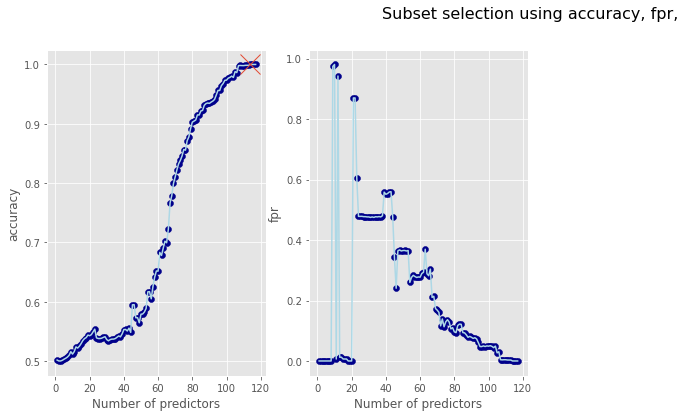

In [16]:
variables = ['accuracy','fpr']
fig = plt.figure(figsize = (18,6))

for i,v in enumerate(variables):
    ax = fig.add_subplot(1, 4, i+1)
    ax.plot(df['numb_features'],df[v], color = 'lightblue')
    ax.scatter(df['numb_features'],df[v], color = 'darkblue')
    if v == 'accuracy':
        ax.plot(df[v].idxmax(),df[v].max(), marker = 'x', markersize = 20)
    else:
        ax.plot(df[v].idxmin(),df[v].min(), markersize = 20)
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)

fig.suptitle('Subset selection using accuracy, fpr, ', fontsize = 16)
plt.show()

In [17]:
##also forward selection, but using Machine learning

In [18]:
!pip install mlxtend

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs_forward = SFS(LogisticRegression(), 
                  k_features=117, 
                  forward=True, 
                  floating=False, 
                  verbose=2,
                  scoring='accuracy',
                  cv=5)

sfs_forward = sfs_forward.fit(np.array(X_train), y_train)

# Get the selected feature subset
selected_features = X_train.columns[list(sfs_forward.k_feature_idx_)]

# Evaluate the model using the selected feature subset
logreg = LogisticRegression()
logreg.fit(X_train[selected_features], y_train)
y_pred = logreg.predict(X_test[selected_features])
accuracy = accuracy_score(y_test, y_pred)

# Calculate FPR using ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
fpr = fpr[1]  # FPR at TPR=0.5 (i.e., when the threshold is set to maximize balanced accuracy)
print('Accuracy:', accuracy)
print('False positive rate:', fpr)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 117 out of 117 | elapsed:    1.9s finished

[2023-03-01 21:48:16] Features: 1/117 -- score: 0.8909549290681366[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 116 out of 116 | elapsed:    2.7s finished

[2023-03-01 21:48:19] Features: 2/117 -- score: 0.9458968983497286[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    2.8s finished

[2023-03-01 21:48:22] Features: 3/117 -- score: 0.9691043966515664[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Don

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    6.0s finished

[2023-03-01 21:50:34] Features: 28/117 -- score: 0.9995805173163663[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  89 out of  89 | elapsed:    6.6s finished

[2023-03-01 21:50:40] Features: 29/117 -- score: 0.9995805173163663[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:    7.0s finished

[2023-03-01 21:50:47] Features: 30/117 -- score: 0.9995805173163663[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:    7.2s finished

[2023-03-01 21:50:55] Features: 

[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:   11.2s finished

[2023-03-01 21:54:05] Features: 56/117 -- score: 0.9995805173163663[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:   12.3s finished

[2023-03-01 21:54:17] Features: 57/117 -- score: 0.9997203774562265[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   11.1s finished

[2023-03-01 21:54:28] Features: 58/117 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:   10.6s finished

[2023-03-01 21:54:39] Features: 59/117 -- score

[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    5.8s finished

[2023-03-01 21:57:51] Features: 85/117 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    5.3s finished

[2023-03-01 21:57:56] Features: 86/117 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    5.2s finished

[2023-03-01 21:58:02] Features: 87/117 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    5.1s finished

[2023-03-01 21:58:07] Features: 88/117 -- score: 1.0[Parallel(n_jobs=1)]: Usi

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.9s finished

[2023-03-01 21:59:27] Features: 114/117 -- score: 1.0[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s finished

[2023-03-01 21:59:28] Features: 115/117 -- score: 0.9998601398601398[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished

[2023-03-01 21:59:28] Features: 116/117 -- score: 0.9998601398601398[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy: 0.9984164687252574
False positive rate: 0.003430531732418525


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished

[2023-03-01 21:59:29] Features: 117/117 -- score: 0.9995805173163663

In [22]:
X_train.columns[list(sfs_forward.k_feature_idx_)]

Index(['cap_shape_BELL', 'cap_shape_CONICAL', 'cap_shape_CONVEX',
       'cap_shape_FLAT', 'cap_shape_KNOBBED', 'cap_shape_SUNKEN',
       'cap_surface_FIBROUS', 'cap_surface_GROOVES', 'cap_surface_SCALY',
       'cap_surface_SMOOTH',
       ...
       'population_SCATTERED', 'population_SEVERAL', 'population_SOLITARY',
       'habitat_GRASSES', 'habitat_LEAVES', 'habitat_MEADOWS', 'habitat_PATHS',
       'habitat_URBAN', 'habitat_WASTE', 'habitat_WOODS'],
      dtype='object', length=117)

In [ ]:
#backward selection

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs_backward = SFS(LogisticRegression(), 
                   k_features=117, 
                   forward=False, 
                   floating=False, 
                   verbose=2,
                   scoring='accuracy',
                   cv=5)

sfs_backward = sfs_backward.fit(np.array(X_train), y_train)

# Get the selected feature subset
selected_features = X_train.columns[list(sfs_backward.k_feature_idx_)]

# Evaluate the model using the selected feature subset
logreg = LogisticRegression()
logreg.fit(X_train[selected_features], y_train)
y_pred = logreg.predict(X_test[selected_features])
accuracy = accuracy_score(y_test, y_pred)

# Calculate FPR using ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
fpr = fpr[1]  # FPR at TPR=0.5 (i.e., when the threshold is set to maximize balanced accuracy)
print('Accuracy:', accuracy)
print('False positive rate:', fpr)
